In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns 

In [2]:
Weather_data = "/Users/hasnainashraf/Desktop/seattle-weather.csv"
df = pd.read_csv(Weather_data) 

In [3]:
df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [4]:
df['date'] = pd.to_datetime(df['date'])

In [5]:
# Date features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

In [6]:
# Missing values
print("Missing values:\n", df.isnull().sum())

Missing values:
 date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
year             0
month            0
day              0
dtype: int64


In [7]:
# season column
df['season'] = df['month'].apply(lambda x: 
    'Winter' if x in [12, 1, 2] else
    'Spring' if x in [3, 4, 5] else
    'Summer' if x in [6, 7, 8] else
    'Fall')

In [8]:
# year-month feature for analysis 
df['year_month'] = df['date'].dt.strftime('%Y-%m')

In [9]:
# numerical features for clustering
features = df[['precipitation', 'temp_max', 'temp_min', 'wind']].copy() 

In [10]:
# standardizing the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [11]:
# determining optimal number of clusters using silhouette score
silhouette_scores = []
k_range = range(2, 11)

In [12]:
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_features)
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {k}, the silhouette score is {silhouette_avg:.4f}")

For n_clusters = 2, the silhouette score is 0.3525
For n_clusters = 3, the silhouette score is 0.3797
For n_clusters = 4, the silhouette score is 0.3889
For n_clusters = 5, the silhouette score is 0.3013
For n_clusters = 6, the silhouette score is 0.3016
For n_clusters = 7, the silhouette score is 0.2940
For n_clusters = 8, the silhouette score is 0.2515
For n_clusters = 9, the silhouette score is 0.2607
For n_clusters = 10, the silhouette score is 0.2548


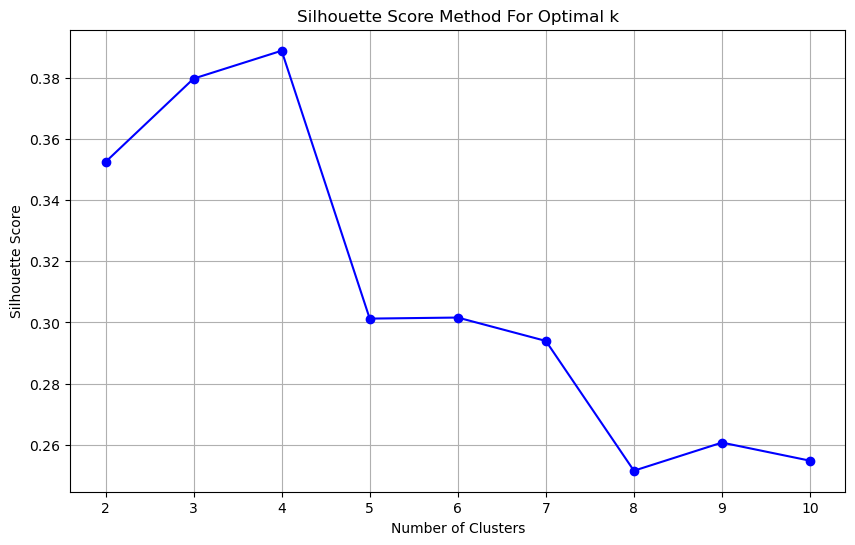

In [13]:
# Plotting silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method For Optimal k')
plt.grid(True) 

In [14]:
# getting optimal k with the highest silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_k}")


Optimal number of clusters: 4


In [15]:
# performing clustering with the k that had the highest silhouette score
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(scaled_features)

In [16]:
# centroids of each cluster in scaled units.
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=features.columns
)
print("\nCluster centers:")
print(cluster_centers)


Cluster centers:
   precipitation   temp_max   temp_min      wind
0       0.567258  23.408226  12.683548  2.804839
1       1.670000  10.488889   3.644667  2.314444
2      23.524490  13.253061   8.144898  4.520408
3       3.472355  11.896246   5.900683  5.159727


In [17]:
# of data points in each cluster
print("\nData points in each cluster:")
print(df['cluster'].value_counts())


Data points in each cluster:
cluster
0    620
1    449
3    294
2     98
Name: count, dtype: int64


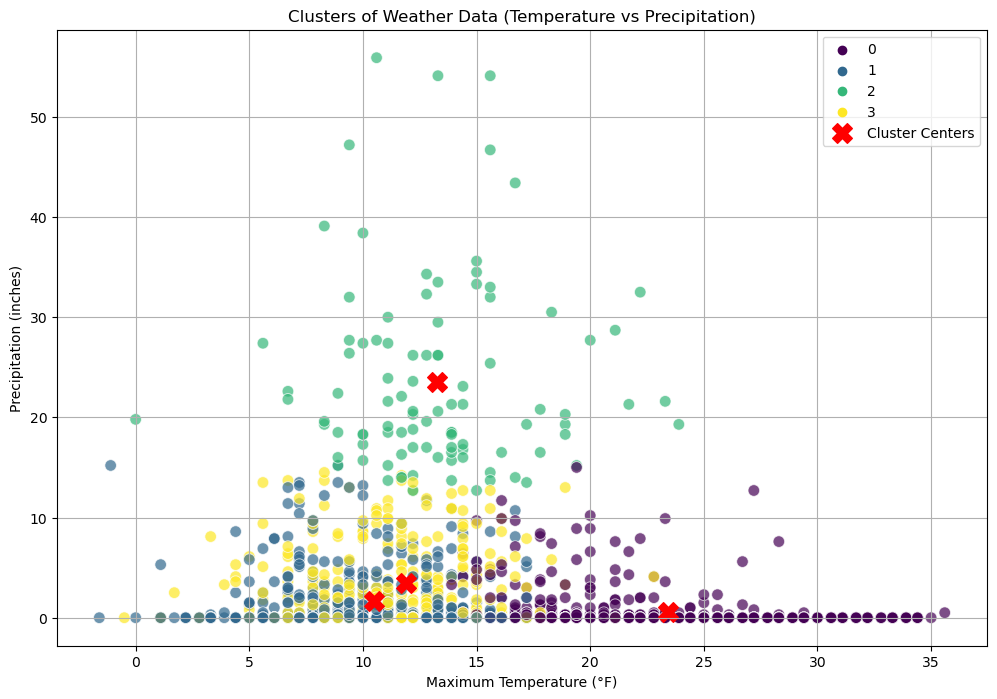

In [18]:
# VISUALIZING THE CLUSTERS - (Temperature vs Precipitation)

plt.figure(figsize=(12, 8))

# data points with cluster labels
sns.scatterplot(
    x='temp_max',
    y='precipitation',
    hue='cluster',
    palette='viridis',
    data=df,
    s=70,
    alpha=0.7
)

# cluster centers
plt.scatter(
    cluster_centers['temp_max'],
    cluster_centers['precipitation'],
    c='red',
    marker='X',
    s=200,
    label='Cluster Centers'
)

# plot
plt.title('Clusters of Weather Data (Temperature vs Precipitation)')
plt.xlabel('Maximum Temperature (°F)')
plt.ylabel('Precipitation (inches)')
plt.legend()
plt.grid(True)

plt.savefig("Clusters of Weather Data.png")
 
plt.show()


In [19]:
# pivot table to see how clusters are distributed across different year-months
year_month_clusters = pd.crosstab(df['year_month'], df['cluster'])

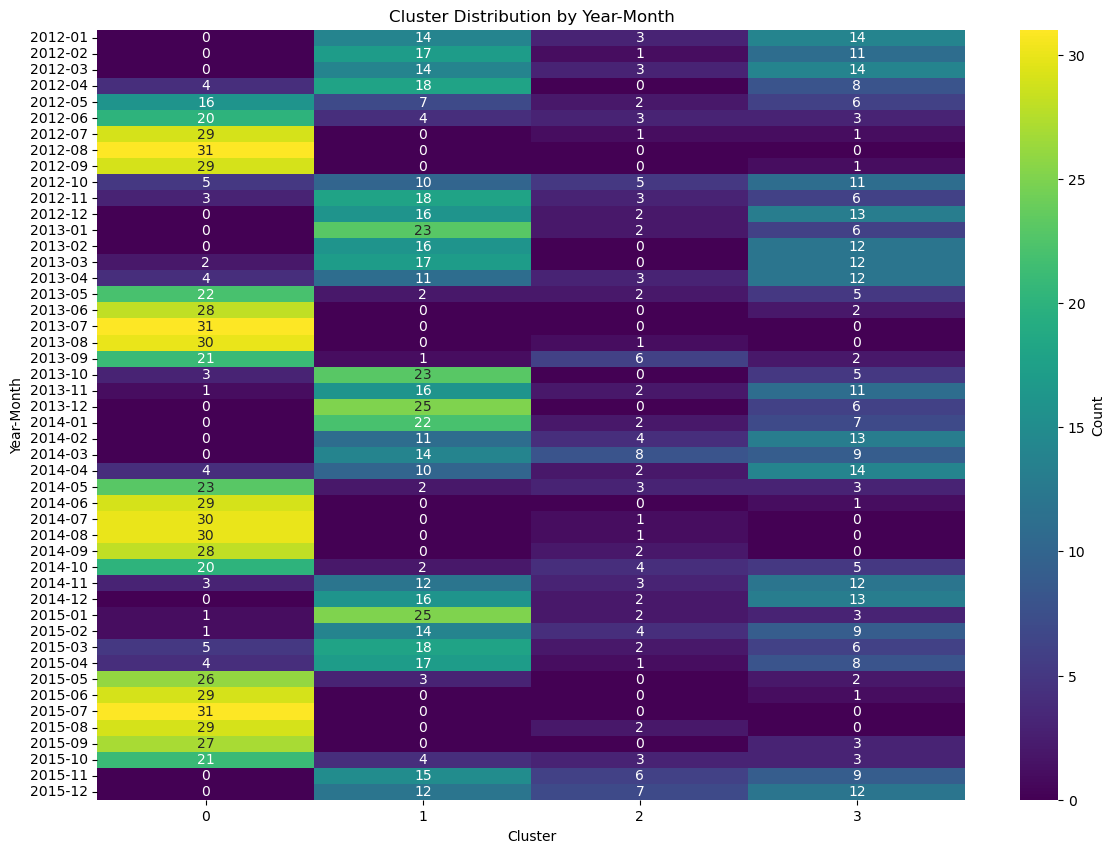

In [20]:
# heatmap of pivot table
plt.figure(figsize=(14, 10))
sns.heatmap(year_month_clusters, cmap='viridis', annot=True, fmt='d', cbar_kws={'label': 'Count'})
plt.title('Cluster Distribution by Year-Month')
plt.xlabel('Cluster')
plt.ylabel('Year-Month') 
plt.savefig("Cluster distribution accross year-months.png")

In [21]:
# clusters by season 
seasonal_clusters = pd.crosstab(df['season'], df['cluster'])
print("\nCluster distribution by season:")
print(seasonal_clusters)


Cluster distribution by season:
cluster    0    1   2    3
season                    
Fall     161  101  34   68
Spring   110  133  26   99
Summer   347    4   9    8
Winter     2  211  29  119


<Figure size 1200x800 with 0 Axes>

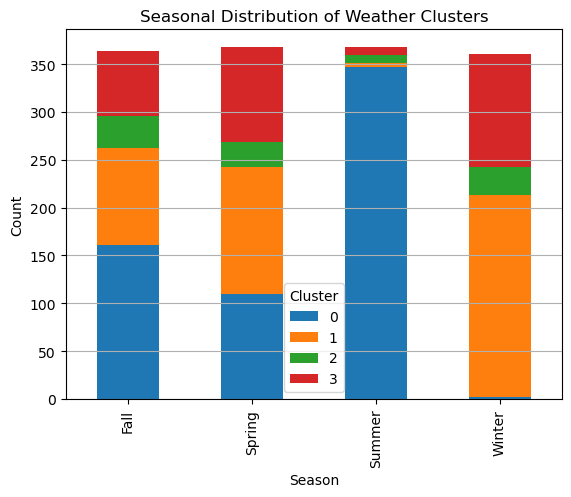

In [22]:
# seasonal distribution of clusters
plt.figure(figsize=(12, 8))
seasonal_clusters.plot(kind='bar', stacked=True)
plt.title('Seasonal Distribution of Weather Clusters')
plt.xlabel('Season')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.grid(axis='y') 
plt.savefig('Seasonal Distribution of Weather Clusters.png')

In [23]:
# Average of features within each cluster, along with their date count
cluster_analysis = df.groupby('cluster').agg({
    'precipitation': 'mean',
    'temp_max': 'mean',
    'temp_min': 'mean',
    'wind': 'mean',
    'date': 'count'
}).rename(columns={'date': 'count_of_dates'})

print("\nDetailed cluster analysis:")
print(cluster_analysis) 


Detailed cluster analysis:
         precipitation   temp_max   temp_min      wind  count_of_dates
cluster                                                               
0             0.567258  23.408226  12.683548  2.804839             620
1             1.669265  10.492428   3.648998  2.310690             449
2            23.524490  13.253061   8.144898  4.520408              98
3             3.467347  11.886054   5.886395  5.155782             294


In [24]:
# What weather conditions are most common in each cluster
weather_by_cluster = pd.crosstab(df['cluster'], df['weather'], normalize='index')
print("\nWeather conditions by cluster (as proportions):")
print(weather_by_cluster)


Weather conditions by cluster (as proportions):
weather   drizzle       fog      rain      snow       sun
cluster                                                  
0        0.040323  0.074194  0.229032  0.000000  0.656452
1        0.053452  0.106904  0.461024  0.020045  0.358575
2        0.000000  0.000000  0.959184  0.040816  0.000000
3        0.013605  0.023810  0.673469  0.044218  0.244898


In [25]:
# Cluster distribution by year
year_clusters = pd.crosstab(df['year'], df['cluster'])
print("\nCluster distribution by year:")
print(year_clusters)


Cluster distribution by year:
cluster    0    1   2   3
year                     
2012     137  118  23  88
2013     142  134  16  73
2014     167   89  32  77
2015     174  108  27  56


<Figure size 1200x800 with 0 Axes>

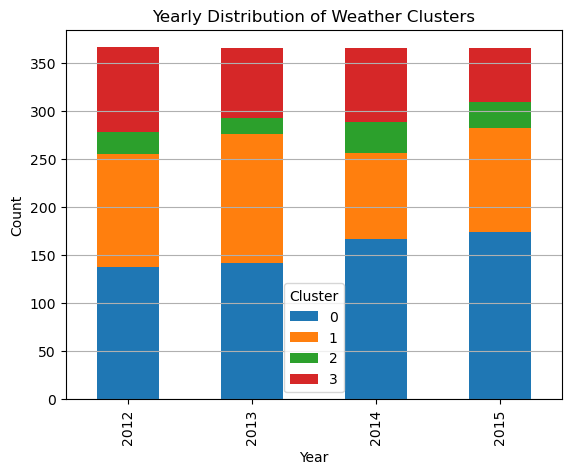

In [26]:
# Plot of cluster distribution by year
plt.figure(figsize=(12, 8))
year_clusters.plot(kind='bar', stacked=True)
plt.title('Yearly Distribution of Weather Clusters')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.grid(axis='y')
plt.savefig('Cluster distribution by year.png')